# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time. 
We want you to test your neural network on MNIST before CelebA.  
Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = '../GAN/data' # Aras: changed to my own path

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data

### MNIST

As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. 
You can view the first number of examples by changing `show_n_images`.

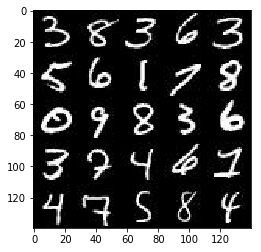

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [8]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  
Since you're going to be generating faces, you won't need the annotations. 
You can view the first number of examples by changing `show_n_images`.

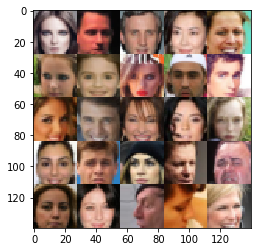

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [10]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  
The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. 
It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data).

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width --> 28
    :param image_height: The input image height --> 28
    :param image_channels: The number of image channels --> 3 RGB
    :param z_dim: The dimension of Z --> n
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # def model_inputs(real_dim, z_dim):
    #     real_size = (32,32,3)
    real_dim = (image_height, image_width, image_channels) # hxwxc
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name='input_real')

    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(dtype=tf.float32, shape=None, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/arasdar/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/arasdar/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/arasdar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/arasdar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/arasdar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instanc

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  
This function should be able to reuse the variabes in the neural network.
Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  
The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def conv2d_xavier(inputs, filters, kernel_size, strides, padding):  #, trainable, reuse
    out_conv = tf.layers.conv2d(inputs, filters, kernel_size, strides, padding, 
                                data_format='channels_last', #strides=(1, 1), padding='valid', 
                                dilation_rate=(1, 1), activation=None, use_bias=True, 
       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32), 
               bias_initializer=tf.zeros_initializer(), kernel_regularizer=None, bias_regularizer=None,
               activity_regularizer=None, trainable=True, name=None, reuse=None)

    return out_conv

In [9]:
def conv2d_transpose_xavier(inputs, filters, kernel_size, strides, padding):  #, trainable, reuse
    out_conv_T = tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides, padding, 
                                data_format='channels_last', #strides=(1, 1), padding='valid', dilation_rate=(1, 1), 
                                  activation=None, use_bias=True, 
       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32), 
               bias_initializer=tf.zeros_initializer(), kernel_regularizer=None, bias_regularizer=None,
               activity_regularizer=None, trainable=True, name=None, reuse=None)

    return out_conv_T

In [10]:
def dense_xavier(inputs, units):
    out_dense = tf.layers.dense(inputs, units, activation=None, use_bias=True,
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32),
        bias_initializer=tf.zeros_initializer(), kernel_regularizer=None, bias_regularizer=None, 
                    activity_regularizer=None, trainable=True, name=None, reuse=None)
    return out_dense

In [11]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s) --> txwxhxc --> tx28x28x3
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # Implementation for DCGAN-svhn
    # def discriminator(x, reuse=False, alpha=0.2):
    alpha=0.2 # for leaky ReLU
    
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input layer is 32x32x3 -> 28x28x3 in this case
#         x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = conv2d_xavier(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(inputs=x1, training=True)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64 -> 14x14x64 with stride 2 ans same image

#         x2 = tf.layers.conv2d(inputs=lrelu1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = conv2d_xavier(inputs=lrelu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(inputs=x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128 -> 7x7x128 with stride 2

#         x3 = tf.layers.conv2d(inputs=lrelu2, filters=256, kernel_size=7, strides=1, padding='same')
        x3 = conv2d_xavier(inputs=lrelu2, filters=256, kernel_size=7, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(inputs=x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 -> 7x7x256 with stride 1 so NO change

        # Flatten it/ flattening layer
        # 1st way
        #         flat = tf.reshape(relu3, (-1, 4*4*256))
        # 2nd way to flattening
        # Feedback tip
        #         Excellent work.
        #         You can flatten a layer with tf.contrib.layers.flatten() 
        #         check out: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
        # flat = tf.contrib.layers.flatten(inputs=relu3)
        flat = tf.reshape(tensor=lrelu3, shape=(-1, 7*7*256), name=None)


        # # How to add dropout and WHERE to add the dropout layer
        # # Dense Layer
        # pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
        # dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
        # dropout = tf.layers.dropout(
        # inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
        # # Logits Layer
        # logits = tf.layers.dense(inputs=dropout, units=10)
        flat = tf.layers.dropout(inputs=flat, rate=0.5, training=True)

#         logits = tf.layers.dense(inputs=flat, units=1) # 1 output unit for 1, 0 or real/fake as the binary output
        logits = dense_xavier(inputs=flat, units=1) # 1 output unit for 1, 0 or real/fake as the binary output
        out = tf.sigmoid(x=logits) # prob/confidence for one output/unit classification

        return out, logits

# # 2nd feedback tips     
# Most of the suggestions are same for both Generator and Discriminator.

# Discriminator
# 1- Using dropout in discriminator so that it is less prone to learning the data distribution.
# 2- Use custom weight initialization. Xavier init is proposed to work best when working with GANs.

# Generator
# 1- Try setting leak for leaky_relu a bit lower. Did you tried 0.1 ?
# 2- Try decreasing the width of layers from 512 -> 64. In context of GANs, 
# a sharp decline in number of filters for Generator helps produce better results.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. 
This function should be able to reuse the variabes in the neural network.  
Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. 
The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #     def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #         x1 = tf.layers.dense(z, 4*4*512)
        # z is z_1x100=mat_txn, t/time/bacth, n/space/num_dim
#         x1 = tf.layers.dense(inputs=z, units=7*7*512) # start from the last layer of discriminator/classifier/recognizer/perdictor
        x1 = dense_xavier(inputs=z, units=7*7*512) # start from the last layer of discriminator/classifier/recognizer/perdictor
        # x1_1x7*7*512 -> 1x7x7x512

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(tensor=x1, shape=(-1, 7, 7, 512), name=None)
        bn1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now -> tx7x7x512, t=1 means one sample/record/image in each fwd/bwd prop/pass/path/route
        
#         x2 = tf.layers.conv2d_transpose(inputs=lrelu1, filters=256, kernel_size=7, strides=1, padding='same')
        x2 = conv2d_transpose_xavier(inputs=lrelu1, filters=256, kernel_size=7, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now -> 7x7x256 with stride=1
        
#         x3 = tf.layers.conv2d_transpose(inputs=lrelu2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = conv2d_transpose_xavier(inputs=lrelu2, filters=128, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now -> tx14x14x128
        
        # # How to add dropout and WHERE to add the dropout layer
        # # Dense Layer
        # pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
        # dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
        # dropout = tf.layers.dropout(
        # inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
        # # Logits Layer
        # logits = tf.layers.dense(inputs=dropout, units=10)
        lrelu3 = tf.layers.dropout(inputs=lrelu3, rate=0.5, training=is_train)

        # Output layer
#         logits = tf.layers.conv2d_transpose(inputs=lrelu3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        logits = conv2d_transpose_xavier(inputs=lrelu3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 32x32x3 now -> tx28x28x3 the actual image size
        
        # prediction and regression -1, +1
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  
The function should return a tuple of (discriminator loss, generator loss).  
Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(z=input_z, out_channel_dim=out_channel_dim) # alpha is included inside
    d_model_real, d_logits_real = discriminator(images=input_real) # alpha included
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True) # alpha included

    # Label smoothing to add noise to the labels for the fake and real labels
    d_loss_real = tf.reduce_mean(input_tensor= 
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, # should be around 1.0
                                        labels=tf.ones_like(d_model_real) * np.random.uniform(low=0.7, high=1.2)))

    d_loss_fake = tf.reduce_mean(input_tensor=
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,  # should close to 0.0 as noise
                                        labels=tf.zeros_like(d_model_fake) + np.random.uniform(low=0.0, high=0.3)))

    g_loss = tf.reduce_mean(input_tensor=
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

# 2nd feedback hints/tips
# The function model_loss is implemented correctly.
# Perfect.
# Now that was the trickiest part (and my personal favorite in GAN :)

# Tips

# 1- Use Label Smoothing for Discriminator loss, will help it generalize better. 
# If you have two target labels: Real=1 and Fake=0, then for each incoming sample, 
# if it is real, then replace the label with a random number between 0.7 and 1.2, 
# and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
# A simple change like labels = tf.ones_like(d_logits_real) * np.random.uniform(0.7, 1.2) will help with 
# the training process. 
# This is known as label smoothing, typically used with classifiers to improve performance.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. 
Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  
The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  
Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. 
Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  
It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    # data_shape, e.g. mnist_dataset.shape == txhxwxc == shape== 0, 1, 2, 3
    input_real, input_z, lr = model_inputs(image_width=data_shape[1], 
                                                       image_height=data_shape[2], 
                                                      image_channels=data_shape[3], 
                                                      z_dim=z_dim)

    # 1st and 2nd Feedback tip
    # Great success has been shown if you wrap g_train_opt with
    # tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    # More details can be found here: http://ruishu.io/2016/12/27/batchnorm/
    # tf.control_dependencies() is used in the batch normalization lessons, 
    # and is necessary to get the normalization layers created
    # with tf.layers.batch_normalization to update their population statistics, 
    # which we need when performing inference.
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        # train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])
        d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=lr, beta1=beta1)
    
    steps = 0 # for printing the generator output every 100 batches
    show_every = 100 # show the generated images
    print_every = 10 # printing out the loss for g and d
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # batches_txn: t== number of minibatches, 
            # n== batch_size/ number of smaples/records/images in each minibatch
            for batch_images in get_batches(batch_size): 
                # TODO: Train Model
                
                # 1st and 2nd Feedback tip
                # Since the images are scaled to -0.5:0.5 and we are using tanh in the generator, 
                # you will likely see improved performance 
                # if you perform batch_images *= 2 in order to scale it to -1:1
                batch_images *= 2

                # for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # txn: t==batch_size, n==z_dim

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate}) # 1st time

                # 1st feedback tip
                # Another tip, while not required, 
                # you can try to run the optimization for the generator twice --> g_opt
                # to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate}) # 2nd time

                # Feedback tip: 1st one
                # You're close! 
                # You may need to tune your discriminator and generator a bit, 
                # but first follow my advice below. 
                # Additionally, you should print the loss after each batch for both of your networks, 
                # that will give you some hints on what you need to change to get good output. 
                # For example, if your discriminator loss goes to zero, 
                # you know you may need to make your generator stronger, or 
                # run the optimizer for it again for each batch.
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z, lr: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "stpes: {:.4f}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show generator output every 100 minibatches training in each epoch
                # one epoch, t minibatches, each minibatch for training/updating the params in gnet and dnet
                if steps % show_every == 0:
                    show_n_images = 4 # nrows=5 , ncols=5, nrows*ncols=25 
                    show_generator_output(sess=sess, n_images=show_n_images, input_z=input_z, 
                                          out_channel_dim=data_shape[3], image_mode=data_image_mode)

### Setting up and fine-tuning the hyperparameters for both datasets

In [17]:
# Hyperparameters for both dataset GANs training, valid, and testing
batch_size = 128
z_dim = 100
learning_rate = 0.0002 # 2/128 = 1/64
beta1 = 0.5

# The hyperparameters in DCGAN SVHN impl recom.
# real_size = (32,32,3) -> (28, 28, 3) in this case for both mnist and celebA datasets
# z_size = 100
# learning_rate = 0.0002
# batch_size = 128
# epochs = 25
# alpha = 0.2
# beta1 = 0.5

# 2nd feedback comments/hints/tips
# Given your network architecture, the choice of hyper-parameter are reasonable.
# Tips

# 1- You selected a good value for beta1. 
# Here's a good post explaining the importance of beta values and which value might be empirically better. 
# Also try lowering it even further, ~0.1 might even produce better results.

# 2- An important point to note is, batch size and learning rate are linked. 
# If the batch size is too small then the gradients will become more unstable and would need to 
# reduce the learning rate.
# Batch size used is on higher side. Try setting a value around 32/64.
# We know that larger batch sizes might speed up the training but can degrade the quality of the model at the same time. 
# This link might help you. 
# You can also read about this in the hyperparameters module in your classroom.

### MNIST
Test your GANs architecture on MNIST.  
After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  
Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... stpes: 10.0000... Discriminator Loss: 0.9612... Generator Loss: 1.4865
Epoch 1/2... stpes: 20.0000... Discriminator Loss: 2.0810... Generator Loss: 0.3107
Epoch 1/2... stpes: 30.0000... Discriminator Loss: 2.2061... Generator Loss: 0.1049
Epoch 1/2... stpes: 40.0000... Discriminator Loss: 1.5088... Generator Loss: 0.1180
Epoch 1/2... stpes: 50.0000... Discriminator Loss: 1.0880... Generator Loss: 0.4092
Epoch 1/2... stpes: 60.0000... Discriminator Loss: 1.0166... Generator Loss: 0.8464
Epoch 1/2... stpes: 70.0000... Discriminator Loss: 0.4476... Generator Loss: 1.5089
Epoch 1/2... stpes: 80.0000... Discriminator Loss: 1.4915... Generator Loss: 0.3995
Epoch 1/2... stpes: 90.0000... Discriminator Loss: 1.6714... Generator Loss: 0.4099
Epoch 1/2... stpes: 100.0000... Discriminator Loss: 1.4071... Generator Loss: 0.1374


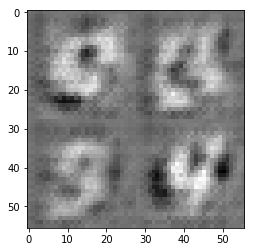

Epoch 1/2... stpes: 110.0000... Discriminator Loss: 1.1692... Generator Loss: 0.5828
Epoch 1/2... stpes: 120.0000... Discriminator Loss: 1.7494... Generator Loss: 0.4555
Epoch 1/2... stpes: 130.0000... Discriminator Loss: 1.3730... Generator Loss: 0.6076
Epoch 1/2... stpes: 140.0000... Discriminator Loss: 1.3637... Generator Loss: 0.2879
Epoch 1/2... stpes: 150.0000... Discriminator Loss: 1.0876... Generator Loss: 0.4043
Epoch 1/2... stpes: 160.0000... Discriminator Loss: 1.2898... Generator Loss: 0.6565
Epoch 1/2... stpes: 170.0000... Discriminator Loss: 1.1426... Generator Loss: 0.8745
Epoch 1/2... stpes: 180.0000... Discriminator Loss: 1.1829... Generator Loss: 0.6083
Epoch 1/2... stpes: 190.0000... Discriminator Loss: 1.3968... Generator Loss: 0.8276
Epoch 1/2... stpes: 200.0000... Discriminator Loss: 1.4142... Generator Loss: 0.1973


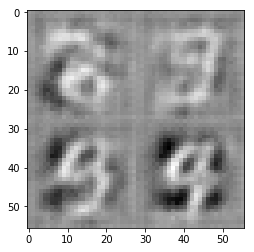

Epoch 1/2... stpes: 210.0000... Discriminator Loss: 1.1304... Generator Loss: 0.2405
Epoch 1/2... stpes: 220.0000... Discriminator Loss: 1.0965... Generator Loss: 0.2039
Epoch 1/2... stpes: 230.0000... Discriminator Loss: 1.1090... Generator Loss: 0.7353
Epoch 1/2... stpes: 240.0000... Discriminator Loss: 0.9347... Generator Loss: 0.6604
Epoch 1/2... stpes: 250.0000... Discriminator Loss: 1.1417... Generator Loss: 0.9239
Epoch 1/2... stpes: 260.0000... Discriminator Loss: 1.1013... Generator Loss: 0.2701
Epoch 1/2... stpes: 270.0000... Discriminator Loss: 1.8504... Generator Loss: 0.0516
Epoch 1/2... stpes: 280.0000... Discriminator Loss: 1.0786... Generator Loss: 0.2852
Epoch 1/2... stpes: 290.0000... Discriminator Loss: 0.9986... Generator Loss: 0.8204
Epoch 1/2... stpes: 300.0000... Discriminator Loss: 1.0831... Generator Loss: 0.9829


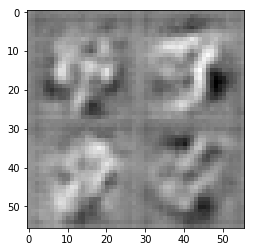

Epoch 1/2... stpes: 310.0000... Discriminator Loss: 1.1459... Generator Loss: 0.5747
Epoch 1/2... stpes: 320.0000... Discriminator Loss: 1.0690... Generator Loss: 0.5233
Epoch 1/2... stpes: 330.0000... Discriminator Loss: 1.1521... Generator Loss: 0.7116
Epoch 1/2... stpes: 340.0000... Discriminator Loss: 0.9279... Generator Loss: 0.7712
Epoch 1/2... stpes: 350.0000... Discriminator Loss: 1.1755... Generator Loss: 0.2067
Epoch 1/2... stpes: 360.0000... Discriminator Loss: 0.9810... Generator Loss: 0.4304
Epoch 1/2... stpes: 370.0000... Discriminator Loss: 3.2279... Generator Loss: 0.0063
Epoch 1/2... stpes: 380.0000... Discriminator Loss: 1.0243... Generator Loss: 0.5623
Epoch 1/2... stpes: 390.0000... Discriminator Loss: 1.1166... Generator Loss: 0.2341
Epoch 1/2... stpes: 400.0000... Discriminator Loss: 1.2394... Generator Loss: 0.1678


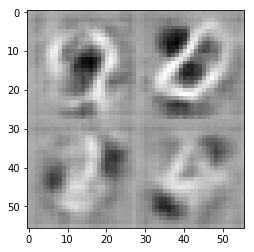

Epoch 1/2... stpes: 410.0000... Discriminator Loss: 1.1565... Generator Loss: 0.2177
Epoch 1/2... stpes: 420.0000... Discriminator Loss: 1.3112... Generator Loss: 0.1836
Epoch 1/2... stpes: 430.0000... Discriminator Loss: 1.1391... Generator Loss: 0.2038
Epoch 1/2... stpes: 440.0000... Discriminator Loss: 1.3941... Generator Loss: 0.1179
Epoch 1/2... stpes: 450.0000... Discriminator Loss: 1.2326... Generator Loss: 0.1848
Epoch 1/2... stpes: 460.0000... Discriminator Loss: 1.2413... Generator Loss: 0.1830
Epoch 2/2... stpes: 470.0000... Discriminator Loss: 1.7791... Generator Loss: 1.6041
Epoch 2/2... stpes: 480.0000... Discriminator Loss: 1.1789... Generator Loss: 0.2784
Epoch 2/2... stpes: 490.0000... Discriminator Loss: 0.9803... Generator Loss: 0.3749
Epoch 2/2... stpes: 500.0000... Discriminator Loss: 1.0628... Generator Loss: 0.4253


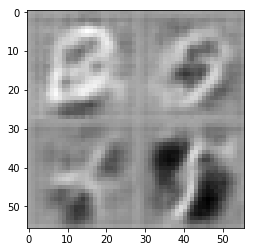

Epoch 2/2... stpes: 510.0000... Discriminator Loss: 1.3452... Generator Loss: 0.1424
Epoch 2/2... stpes: 520.0000... Discriminator Loss: 1.2106... Generator Loss: 0.3281
Epoch 2/2... stpes: 530.0000... Discriminator Loss: 1.1424... Generator Loss: 0.6729
Epoch 2/2... stpes: 540.0000... Discriminator Loss: 1.0568... Generator Loss: 0.5663
Epoch 2/2... stpes: 550.0000... Discriminator Loss: 1.0490... Generator Loss: 0.6201
Epoch 2/2... stpes: 560.0000... Discriminator Loss: 1.2309... Generator Loss: 0.8662
Epoch 2/2... stpes: 570.0000... Discriminator Loss: 1.0276... Generator Loss: 0.7808
Epoch 2/2... stpes: 580.0000... Discriminator Loss: 1.1797... Generator Loss: 0.9420
Epoch 2/2... stpes: 590.0000... Discriminator Loss: 1.6093... Generator Loss: 0.0617
Epoch 2/2... stpes: 600.0000... Discriminator Loss: 1.1067... Generator Loss: 0.3821


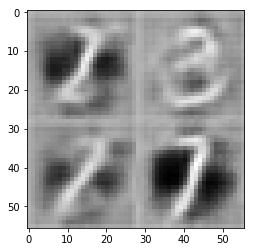

Epoch 2/2... stpes: 610.0000... Discriminator Loss: 1.0323... Generator Loss: 0.4410
Epoch 2/2... stpes: 620.0000... Discriminator Loss: 1.3128... Generator Loss: 0.9758
Epoch 2/2... stpes: 630.0000... Discriminator Loss: 1.0611... Generator Loss: 0.2915
Epoch 2/2... stpes: 640.0000... Discriminator Loss: 0.9817... Generator Loss: 0.2831
Epoch 2/2... stpes: 650.0000... Discriminator Loss: 1.2427... Generator Loss: 0.2504
Epoch 2/2... stpes: 660.0000... Discriminator Loss: 1.0494... Generator Loss: 0.7022
Epoch 2/2... stpes: 670.0000... Discriminator Loss: 1.5367... Generator Loss: 0.0938
Epoch 2/2... stpes: 680.0000... Discriminator Loss: 1.3434... Generator Loss: 0.1437
Epoch 2/2... stpes: 690.0000... Discriminator Loss: 1.0125... Generator Loss: 0.7680
Epoch 2/2... stpes: 700.0000... Discriminator Loss: 1.0941... Generator Loss: 0.7511


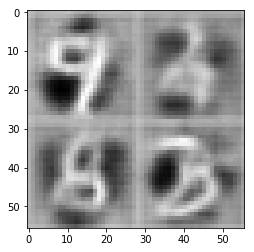

Epoch 2/2... stpes: 710.0000... Discriminator Loss: 1.0017... Generator Loss: 0.5301
Epoch 2/2... stpes: 720.0000... Discriminator Loss: 0.9556... Generator Loss: 0.4238
Epoch 2/2... stpes: 730.0000... Discriminator Loss: 1.0842... Generator Loss: 0.3697
Epoch 2/2... stpes: 740.0000... Discriminator Loss: 1.1236... Generator Loss: 0.1771
Epoch 2/2... stpes: 750.0000... Discriminator Loss: 1.0270... Generator Loss: 0.7492
Epoch 2/2... stpes: 760.0000... Discriminator Loss: 1.0490... Generator Loss: 0.8153
Epoch 2/2... stpes: 770.0000... Discriminator Loss: 1.0030... Generator Loss: 0.6973
Epoch 2/2... stpes: 780.0000... Discriminator Loss: 1.4264... Generator Loss: 0.1333
Epoch 2/2... stpes: 790.0000... Discriminator Loss: 1.2096... Generator Loss: 0.9165
Epoch 2/2... stpes: 800.0000... Discriminator Loss: 0.8473... Generator Loss: 0.4854


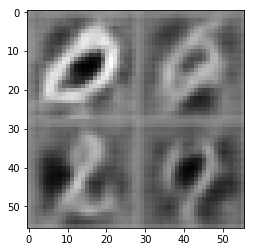

Epoch 2/2... stpes: 810.0000... Discriminator Loss: 0.9574... Generator Loss: 0.3736
Epoch 2/2... stpes: 820.0000... Discriminator Loss: 1.3296... Generator Loss: 0.1637
Epoch 2/2... stpes: 830.0000... Discriminator Loss: 0.9564... Generator Loss: 0.2434
Epoch 2/2... stpes: 840.0000... Discriminator Loss: 1.0518... Generator Loss: 0.3052
Epoch 2/2... stpes: 850.0000... Discriminator Loss: 1.0946... Generator Loss: 0.6371
Epoch 2/2... stpes: 860.0000... Discriminator Loss: 1.0586... Generator Loss: 0.2892
Epoch 2/2... stpes: 870.0000... Discriminator Loss: 1.1487... Generator Loss: 0.2402
Epoch 2/2... stpes: 880.0000... Discriminator Loss: 1.0160... Generator Loss: 0.2891
Epoch 2/2... stpes: 890.0000... Discriminator Loss: 1.1505... Generator Loss: 0.2747
Epoch 2/2... stpes: 900.0000... Discriminator Loss: 0.9291... Generator Loss: 0.5481


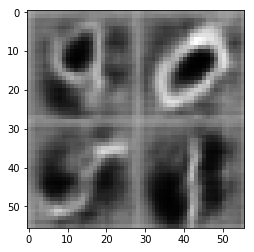

Epoch 2/2... stpes: 910.0000... Discriminator Loss: 1.2091... Generator Loss: 0.6760
Epoch 2/2... stpes: 920.0000... Discriminator Loss: 1.1809... Generator Loss: 0.1869
Epoch 2/2... stpes: 930.0000... Discriminator Loss: 0.8380... Generator Loss: 0.6501


In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  
It will take around 20 minutes on the average GPU to run one epoch.  
You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... stpes: 10.0000... Discriminator Loss: 1.6040... Generator Loss: 1.4375
Epoch 1/1... stpes: 20.0000... Discriminator Loss: 0.8878... Generator Loss: 2.3242
Epoch 1/1... stpes: 30.0000... Discriminator Loss: 1.4921... Generator Loss: 4.1406
Epoch 1/1... stpes: 40.0000... Discriminator Loss: 1.0655... Generator Loss: 1.8875
Epoch 1/1... stpes: 50.0000... Discriminator Loss: 0.5300... Generator Loss: 2.6380
Epoch 1/1... stpes: 60.0000... Discriminator Loss: 0.7450... Generator Loss: 1.7828
Epoch 1/1... stpes: 70.0000... Discriminator Loss: 1.5306... Generator Loss: 0.5958
Epoch 1/1... stpes: 80.0000... Discriminator Loss: 1.2455... Generator Loss: 0.6463
Epoch 1/1... stpes: 90.0000... Discriminator Loss: 0.9593... Generator Loss: 1.1789
Epoch 1/1... stpes: 100.0000... Discriminator Loss: 0.9504... Generator Loss: 1.9420


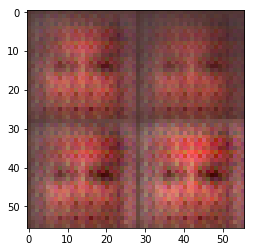

Epoch 1/1... stpes: 110.0000... Discriminator Loss: 0.9551... Generator Loss: 1.1858
Epoch 1/1... stpes: 120.0000... Discriminator Loss: 0.8731... Generator Loss: 0.9412
Epoch 1/1... stpes: 130.0000... Discriminator Loss: 0.7979... Generator Loss: 1.2745
Epoch 1/1... stpes: 140.0000... Discriminator Loss: 1.6690... Generator Loss: 0.2705
Epoch 1/1... stpes: 150.0000... Discriminator Loss: 1.5038... Generator Loss: 0.2633
Epoch 1/1... stpes: 160.0000... Discriminator Loss: 1.3146... Generator Loss: 0.5238
Epoch 1/1... stpes: 170.0000... Discriminator Loss: 1.2969... Generator Loss: 0.4475
Epoch 1/1... stpes: 180.0000... Discriminator Loss: 0.9729... Generator Loss: 0.6867
Epoch 1/1... stpes: 190.0000... Discriminator Loss: 1.1442... Generator Loss: 1.1655
Epoch 1/1... stpes: 200.0000... Discriminator Loss: 1.2217... Generator Loss: 0.5161


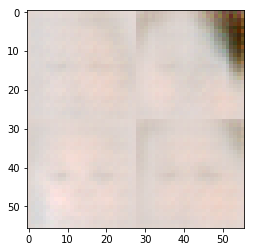

Epoch 1/1... stpes: 210.0000... Discriminator Loss: 1.5833... Generator Loss: 0.2812
Epoch 1/1... stpes: 220.0000... Discriminator Loss: 1.6123... Generator Loss: 0.3843
Epoch 1/1... stpes: 230.0000... Discriminator Loss: 1.3588... Generator Loss: 0.3579
Epoch 1/1... stpes: 240.0000... Discriminator Loss: 1.4045... Generator Loss: 0.5617
Epoch 1/1... stpes: 250.0000... Discriminator Loss: 1.7132... Generator Loss: 0.4177
Epoch 1/1... stpes: 260.0000... Discriminator Loss: 1.8076... Generator Loss: 0.1517
Epoch 1/1... stpes: 270.0000... Discriminator Loss: 1.5801... Generator Loss: 0.2856
Epoch 1/1... stpes: 280.0000... Discriminator Loss: 1.6276... Generator Loss: 0.2747
Epoch 1/1... stpes: 290.0000... Discriminator Loss: 1.6384... Generator Loss: 0.5906
Epoch 1/1... stpes: 300.0000... Discriminator Loss: 1.6650... Generator Loss: 0.4722


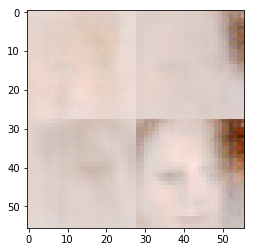

Epoch 1/1... stpes: 310.0000... Discriminator Loss: 1.9080... Generator Loss: 0.2412
Epoch 1/1... stpes: 320.0000... Discriminator Loss: 1.6976... Generator Loss: 0.3309
Epoch 1/1... stpes: 330.0000... Discriminator Loss: 1.6461... Generator Loss: 0.5366
Epoch 1/1... stpes: 340.0000... Discriminator Loss: 1.6262... Generator Loss: 0.5571
Epoch 1/1... stpes: 350.0000... Discriminator Loss: 1.4482... Generator Loss: 0.3693
Epoch 1/1... stpes: 360.0000... Discriminator Loss: 1.7995... Generator Loss: 0.4413
Epoch 1/1... stpes: 370.0000... Discriminator Loss: 1.6727... Generator Loss: 0.2667
Epoch 1/1... stpes: 380.0000... Discriminator Loss: 1.5240... Generator Loss: 0.4335
Epoch 1/1... stpes: 390.0000... Discriminator Loss: 1.6196... Generator Loss: 0.4197
Epoch 1/1... stpes: 400.0000... Discriminator Loss: 1.5646... Generator Loss: 0.3961


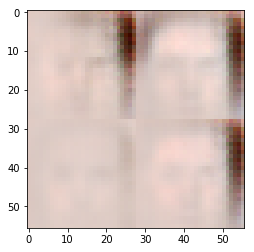

Epoch 1/1... stpes: 410.0000... Discriminator Loss: 1.4521... Generator Loss: 0.5298
Epoch 1/1... stpes: 420.0000... Discriminator Loss: 1.6848... Generator Loss: 0.4073
Epoch 1/1... stpes: 430.0000... Discriminator Loss: 1.5714... Generator Loss: 0.4206
Epoch 1/1... stpes: 440.0000... Discriminator Loss: 1.6220... Generator Loss: 0.3942
Epoch 1/1... stpes: 450.0000... Discriminator Loss: 1.5196... Generator Loss: 0.5186
Epoch 1/1... stpes: 460.0000... Discriminator Loss: 1.6025... Generator Loss: 0.5122
Epoch 1/1... stpes: 470.0000... Discriminator Loss: 1.7140... Generator Loss: 0.4007
Epoch 1/1... stpes: 480.0000... Discriminator Loss: 1.8195... Generator Loss: 0.5001
Epoch 1/1... stpes: 490.0000... Discriminator Loss: 1.5781... Generator Loss: 0.4510
Epoch 1/1... stpes: 500.0000... Discriminator Loss: 1.7887... Generator Loss: 0.4006


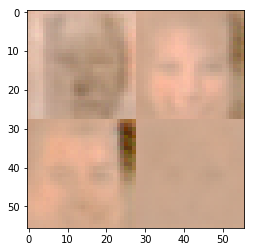

Epoch 1/1... stpes: 510.0000... Discriminator Loss: 1.4639... Generator Loss: 0.5229
Epoch 1/1... stpes: 520.0000... Discriminator Loss: 1.6926... Generator Loss: 0.3776
Epoch 1/1... stpes: 530.0000... Discriminator Loss: 1.7023... Generator Loss: 0.4111
Epoch 1/1... stpes: 540.0000... Discriminator Loss: 1.5389... Generator Loss: 0.5222
Epoch 1/1... stpes: 550.0000... Discriminator Loss: 1.4293... Generator Loss: 0.5181
Epoch 1/1... stpes: 560.0000... Discriminator Loss: 1.5307... Generator Loss: 0.4234
Epoch 1/1... stpes: 570.0000... Discriminator Loss: 1.4424... Generator Loss: 0.4166
Epoch 1/1... stpes: 580.0000... Discriminator Loss: 1.6449... Generator Loss: 0.4922
Epoch 1/1... stpes: 590.0000... Discriminator Loss: 1.5472... Generator Loss: 0.3987
Epoch 1/1... stpes: 600.0000... Discriminator Loss: 1.6485... Generator Loss: 0.4005


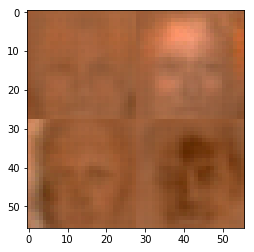

Epoch 1/1... stpes: 610.0000... Discriminator Loss: 1.4605... Generator Loss: 0.5191
Epoch 1/1... stpes: 620.0000... Discriminator Loss: 1.6958... Generator Loss: 0.3792
Epoch 1/1... stpes: 630.0000... Discriminator Loss: 1.5401... Generator Loss: 0.4122
Epoch 1/1... stpes: 640.0000... Discriminator Loss: 1.5988... Generator Loss: 0.3467
Epoch 1/1... stpes: 650.0000... Discriminator Loss: 1.6566... Generator Loss: 0.4411
Epoch 1/1... stpes: 660.0000... Discriminator Loss: 1.6166... Generator Loss: 0.3637
Epoch 1/1... stpes: 670.0000... Discriminator Loss: 1.5453... Generator Loss: 0.4340
Epoch 1/1... stpes: 680.0000... Discriminator Loss: 1.6405... Generator Loss: 0.4137
Epoch 1/1... stpes: 690.0000... Discriminator Loss: 1.3745... Generator Loss: 0.5263
Epoch 1/1... stpes: 700.0000... Discriminator Loss: 1.4813... Generator Loss: 0.4977


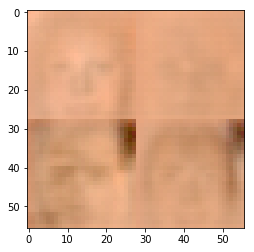

Epoch 1/1... stpes: 710.0000... Discriminator Loss: 1.5654... Generator Loss: 0.3747
Epoch 1/1... stpes: 720.0000... Discriminator Loss: 1.4361... Generator Loss: 0.4362
Epoch 1/1... stpes: 730.0000... Discriminator Loss: 1.5035... Generator Loss: 0.4601
Epoch 1/1... stpes: 740.0000... Discriminator Loss: 1.4585... Generator Loss: 0.4824
Epoch 1/1... stpes: 750.0000... Discriminator Loss: 1.3810... Generator Loss: 0.4560
Epoch 1/1... stpes: 760.0000... Discriminator Loss: 1.4675... Generator Loss: 0.4610
Epoch 1/1... stpes: 770.0000... Discriminator Loss: 1.3840... Generator Loss: 0.4373
Epoch 1/1... stpes: 780.0000... Discriminator Loss: 1.5359... Generator Loss: 0.4315
Epoch 1/1... stpes: 790.0000... Discriminator Loss: 1.4753... Generator Loss: 0.4478
Epoch 1/1... stpes: 800.0000... Discriminator Loss: 1.5148... Generator Loss: 0.3491


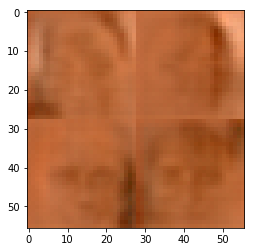

Epoch 1/1... stpes: 810.0000... Discriminator Loss: 1.5029... Generator Loss: 0.4624
Epoch 1/1... stpes: 820.0000... Discriminator Loss: 1.5371... Generator Loss: 0.4401
Epoch 1/1... stpes: 830.0000... Discriminator Loss: 1.4083... Generator Loss: 0.4607
Epoch 1/1... stpes: 840.0000... Discriminator Loss: 1.3410... Generator Loss: 0.3977
Epoch 1/1... stpes: 850.0000... Discriminator Loss: 1.4375... Generator Loss: 0.4401
Epoch 1/1... stpes: 860.0000... Discriminator Loss: 1.4237... Generator Loss: 0.4744
Epoch 1/1... stpes: 870.0000... Discriminator Loss: 1.5898... Generator Loss: 0.4161
Epoch 1/1... stpes: 880.0000... Discriminator Loss: 1.4989... Generator Loss: 0.4064
Epoch 1/1... stpes: 890.0000... Discriminator Loss: 1.4527... Generator Loss: 0.3873
Epoch 1/1... stpes: 900.0000... Discriminator Loss: 1.4239... Generator Loss: 0.5786


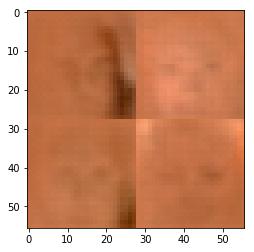

Epoch 1/1... stpes: 910.0000... Discriminator Loss: 1.5068... Generator Loss: 0.4174
Epoch 1/1... stpes: 920.0000... Discriminator Loss: 1.4132... Generator Loss: 0.4526
Epoch 1/1... stpes: 930.0000... Discriminator Loss: 1.5851... Generator Loss: 0.3803
Epoch 1/1... stpes: 940.0000... Discriminator Loss: 1.5552... Generator Loss: 0.3876
Epoch 1/1... stpes: 950.0000... Discriminator Loss: 1.3342... Generator Loss: 0.4348
Epoch 1/1... stpes: 960.0000... Discriminator Loss: 1.5205... Generator Loss: 0.4261
Epoch 1/1... stpes: 970.0000... Discriminator Loss: 1.3975... Generator Loss: 0.3905
Epoch 1/1... stpes: 980.0000... Discriminator Loss: 1.4969... Generator Loss: 0.4024
Epoch 1/1... stpes: 990.0000... Discriminator Loss: 1.5384... Generator Loss: 0.4254
Epoch 1/1... stpes: 1000.0000... Discriminator Loss: 1.3807... Generator Loss: 0.4205


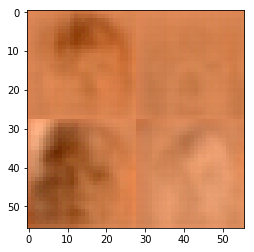

Epoch 1/1... stpes: 1010.0000... Discriminator Loss: 1.5108... Generator Loss: 0.4258
Epoch 1/1... stpes: 1020.0000... Discriminator Loss: 1.3861... Generator Loss: 0.4504
Epoch 1/1... stpes: 1030.0000... Discriminator Loss: 1.5076... Generator Loss: 0.3913
Epoch 1/1... stpes: 1040.0000... Discriminator Loss: 1.4431... Generator Loss: 0.3889
Epoch 1/1... stpes: 1050.0000... Discriminator Loss: 1.3931... Generator Loss: 0.4747
Epoch 1/1... stpes: 1060.0000... Discriminator Loss: 1.4533... Generator Loss: 0.4593
Epoch 1/1... stpes: 1070.0000... Discriminator Loss: 1.4152... Generator Loss: 0.3912
Epoch 1/1... stpes: 1080.0000... Discriminator Loss: 1.4055... Generator Loss: 0.4397
Epoch 1/1... stpes: 1090.0000... Discriminator Loss: 1.3308... Generator Loss: 0.4715
Epoch 1/1... stpes: 1100.0000... Discriminator Loss: 1.4463... Generator Loss: 0.4342


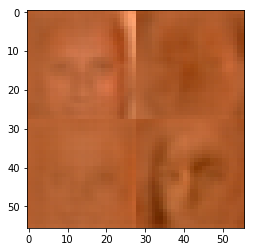

Epoch 1/1... stpes: 1110.0000... Discriminator Loss: 1.4584... Generator Loss: 0.4365
Epoch 1/1... stpes: 1120.0000... Discriminator Loss: 1.4174... Generator Loss: 0.3986
Epoch 1/1... stpes: 1130.0000... Discriminator Loss: 1.3348... Generator Loss: 0.4752
Epoch 1/1... stpes: 1140.0000... Discriminator Loss: 1.3816... Generator Loss: 0.4264
Epoch 1/1... stpes: 1150.0000... Discriminator Loss: 1.3636... Generator Loss: 0.4361
Epoch 1/1... stpes: 1160.0000... Discriminator Loss: 1.4077... Generator Loss: 0.4325
Epoch 1/1... stpes: 1170.0000... Discriminator Loss: 1.3640... Generator Loss: 0.3897
Epoch 1/1... stpes: 1180.0000... Discriminator Loss: 1.4875... Generator Loss: 0.3604
Epoch 1/1... stpes: 1190.0000... Discriminator Loss: 1.3467... Generator Loss: 0.4902
Epoch 1/1... stpes: 1200.0000... Discriminator Loss: 1.4123... Generator Loss: 0.3807


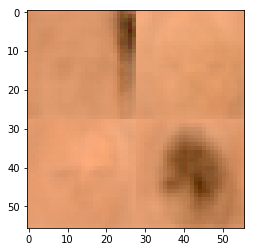

Epoch 1/1... stpes: 1210.0000... Discriminator Loss: 1.3565... Generator Loss: 0.4726
Epoch 1/1... stpes: 1220.0000... Discriminator Loss: 1.3897... Generator Loss: 0.4664
Epoch 1/1... stpes: 1230.0000... Discriminator Loss: 1.4688... Generator Loss: 0.5238
Epoch 1/1... stpes: 1240.0000... Discriminator Loss: 1.3702... Generator Loss: 0.4534
Epoch 1/1... stpes: 1250.0000... Discriminator Loss: 1.4047... Generator Loss: 0.4705
Epoch 1/1... stpes: 1260.0000... Discriminator Loss: 1.4187... Generator Loss: 0.4493
Epoch 1/1... stpes: 1270.0000... Discriminator Loss: 1.3767... Generator Loss: 0.4146
Epoch 1/1... stpes: 1280.0000... Discriminator Loss: 1.4451... Generator Loss: 0.4221
Epoch 1/1... stpes: 1290.0000... Discriminator Loss: 1.4641... Generator Loss: 0.4065
Epoch 1/1... stpes: 1300.0000... Discriminator Loss: 1.3721... Generator Loss: 0.4986


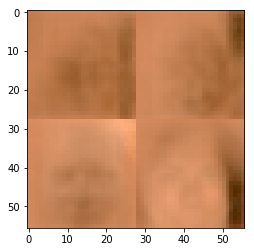

Epoch 1/1... stpes: 1310.0000... Discriminator Loss: 1.4878... Generator Loss: 0.3972
Epoch 1/1... stpes: 1320.0000... Discriminator Loss: 1.3728... Generator Loss: 0.4725
Epoch 1/1... stpes: 1330.0000... Discriminator Loss: 1.3523... Generator Loss: 0.4784
Epoch 1/1... stpes: 1340.0000... Discriminator Loss: 1.3616... Generator Loss: 0.4713
Epoch 1/1... stpes: 1350.0000... Discriminator Loss: 1.4729... Generator Loss: 0.4547
Epoch 1/1... stpes: 1360.0000... Discriminator Loss: 1.4672... Generator Loss: 0.4985
Epoch 1/1... stpes: 1370.0000... Discriminator Loss: 1.4243... Generator Loss: 0.4331
Epoch 1/1... stpes: 1380.0000... Discriminator Loss: 1.4190... Generator Loss: 0.4415
Epoch 1/1... stpes: 1390.0000... Discriminator Loss: 1.4080... Generator Loss: 0.4364
Epoch 1/1... stpes: 1400.0000... Discriminator Loss: 1.3725... Generator Loss: 0.4154


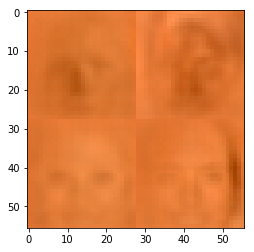

Epoch 1/1... stpes: 1410.0000... Discriminator Loss: 1.4184... Generator Loss: 0.4265
Epoch 1/1... stpes: 1420.0000... Discriminator Loss: 1.4117... Generator Loss: 0.4951
Epoch 1/1... stpes: 1430.0000... Discriminator Loss: 1.4119... Generator Loss: 0.4264
Epoch 1/1... stpes: 1440.0000... Discriminator Loss: 1.3049... Generator Loss: 0.4944
Epoch 1/1... stpes: 1450.0000... Discriminator Loss: 1.3679... Generator Loss: 0.4328
Epoch 1/1... stpes: 1460.0000... Discriminator Loss: 1.3891... Generator Loss: 0.4738
Epoch 1/1... stpes: 1470.0000... Discriminator Loss: 1.4658... Generator Loss: 0.5280
Epoch 1/1... stpes: 1480.0000... Discriminator Loss: 1.3925... Generator Loss: 0.4124
Epoch 1/1... stpes: 1490.0000... Discriminator Loss: 1.3233... Generator Loss: 0.4587
Epoch 1/1... stpes: 1500.0000... Discriminator Loss: 1.3541... Generator Loss: 0.4525


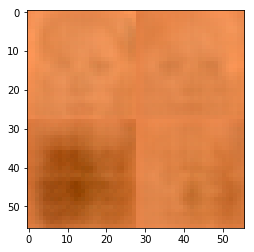

Epoch 1/1... stpes: 1510.0000... Discriminator Loss: 1.3799... Generator Loss: 0.5106
Epoch 1/1... stpes: 1520.0000... Discriminator Loss: 1.4158... Generator Loss: 0.4167
Epoch 1/1... stpes: 1530.0000... Discriminator Loss: 1.4463... Generator Loss: 0.4178
Epoch 1/1... stpes: 1540.0000... Discriminator Loss: 1.3051... Generator Loss: 0.4232
Epoch 1/1... stpes: 1550.0000... Discriminator Loss: 1.3496... Generator Loss: 0.4469
Epoch 1/1... stpes: 1560.0000... Discriminator Loss: 1.3755... Generator Loss: 0.4728
Epoch 1/1... stpes: 1570.0000... Discriminator Loss: 1.3929... Generator Loss: 0.4689
Epoch 1/1... stpes: 1580.0000... Discriminator Loss: 1.3181... Generator Loss: 0.3965


In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.